# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [62]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [63]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [64]:
print('mean_height =\t', round(np.mean(d.height), 3))
print('std_height =\t', round(np.std(d.height), 3))

mean_height =	 154.597
std_height =	 7.731


## Task 1. Prior predictive checks

In [65]:
model_ppc=CmdStanModel(stan_file='/home/4_Linear_models/height_1_ppc.stan')

number_of_samples = 1000
sim=model_ppc.sample(iter_sampling=number_of_samples,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,
                     refresh=number_of_samples)

df = sim.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot histograms of mi, sigma and simulated height.

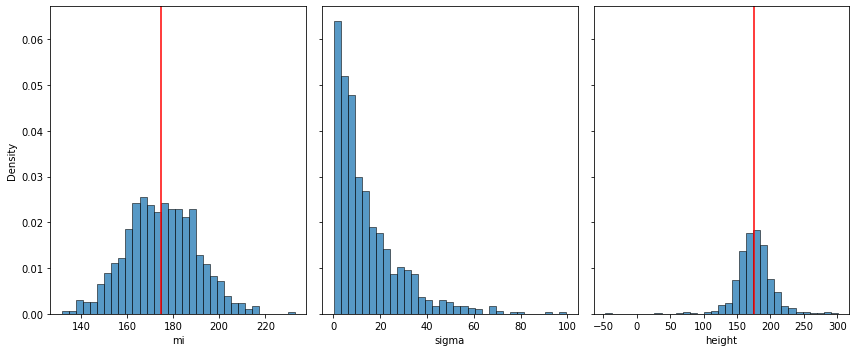

mean_mi 174.896652
mean_height 175.93569300000001


In [66]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5), sharey=True)
sns.histplot(data=df, x="mi", stat="density", ax=ax[0], bins=33)
ax[0].axvline(np.mean(df.mi), color='red')
sns.histplot(data=df, x="sigma", stat="density", ax=ax[1], bins=33)
sns.histplot(data=df, x="height", stat="density", ax=ax[2], bins=33)
ax[2].axvline(np.mean(df.height), color='red')
plt.tight_layout()
plt.show()
print('mean_mi', np.mean(df.mi))
print('mean_height', np.mean(df.height))

2. Plot a joint distribution of mi and sigma.

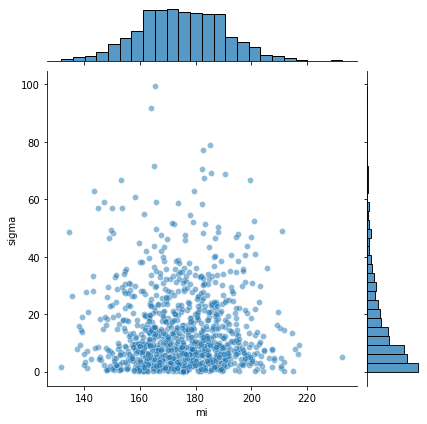

In [67]:
sns.jointplot(data=df, x='mi', y='sigma', alpha=0.5)

3. Check if samples are consistent with priors.

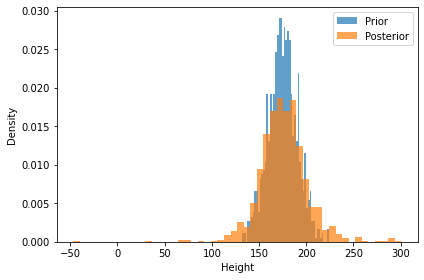

In [68]:
height_prior = np.random.normal(175, 15, size=number_of_samples)

_, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(height_prior, bins=50, alpha=0.7, density=True, label='Prior')
ax.hist(df.height, bins=50, alpha=0.7, density=True, label='Posterior')
ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.legend()
plt.tight_layout()
plt.show()

4. Correct prior parameters to make them reasonably spreaded out. - completed

5. Check if observed data is possible to obtain using priors.

In [69]:
if np.all(height_prior >= np.percentile(df.height, 2.5)) and np.all(height_prior <= np.percentile(df.height, 97.5)):
    print("Observed data is possible to obtain using priors.")
else:
    print("Observed data is not possible to obtain using priors.")

Observed data is possible to obtain using priors.


## Task 2. Model fit and evaluation

In [70]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [71]:
fit=model_1_fit.sample(data=dict(N=len(d), list_of_heights=d.height.values),
                       seed=28052020)

df_model_1_fit = fit.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


1. Plot a joint distribution of fitted mi and sigma.

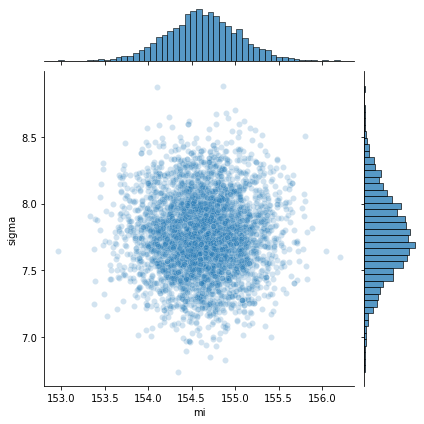

In [72]:
sns.jointplot(data=df_model_1_fit, x='mi', y='sigma', alpha=0.2)
plt.show()

2. Plot histograms of data and simulated heights and evaluate the quality of model.

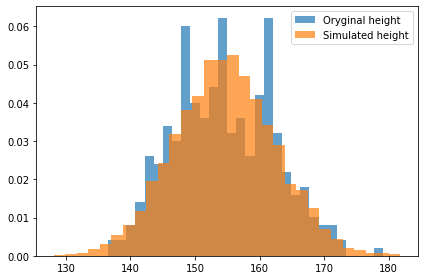

In [73]:
_, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(d.height, bins=30, alpha=0.7, density=True, label='Oryginal height')
ax.hist(df_model_1_fit.height, bins=30, alpha=0.7, density=True, label='Simulated height')
ax.legend()
plt.tight_layout()
plt.show()

The model appears to have a good fit to the data based on the mean and standard deviation, but there are some discrepancies between the distribution of the actual data and the distribution predicted by the model.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [74]:
d['c_weight'] = d.weight - d.weight.mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
print(data_sim)


{'N': 50, 'weight': array([-13.91943352, -13.26797358, -12.61651364, -11.9650537 ,
       -11.31359376, -10.66213383, -10.01067389,  -9.35921395,
        -8.70775401,  -8.05629407,  -7.40483413,  -6.75337419,
        -6.10191425,  -5.45045432,  -4.79899438,  -4.14753444,
        -3.4960745 ,  -2.84461456,  -2.19315462,  -1.54169468,
        -0.89023474,  -0.23877481,   0.41268513,   1.06414507,
         1.71560501,   2.36706495,   3.01852489,   3.66998483,
         4.32144477,   4.9729047 ,   5.62436464,   6.27582458,
         6.92728452,   7.57874446,   8.2302044 ,   8.88166434,
         9.53312428,  10.18458421,  10.83604415,  11.48750409,
        12.13896403,  12.79042397,  13.44188391,  14.09334385,
        14.74480379,  15.39626373,  16.04772366,  16.6991836 ,
        17.35064354,  18.00210348])}


## Task 4. Prior predictive checks
 

In [75]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df_model_ppc = sim.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [76]:
df_model_ppc.head()

,lp__,accept_stat__,height[1],height[2],height[3],height[4],height[5],height[6],height[7],height[8],...,height[44],height[45],height[46],height[47],height[48],height[49],height[50],alpha,beta,sigma
0,0.0,0.0,110.278,81.6423,123.038,149.2610,178.0170,154.325,150.15900,156.1890,...,330.9270,299.5050,323.31700,334.29700,362.3710,356.8060,369.8290,215.623,7.771810,22.213700
1,0.0,0.0,158.061,157.9790,157.933,157.9250,157.8840,157.805,157.75900,157.5150,...,156.0480,155.9370,156.01500,155.84200,155.8760,155.9480,155.7890,157.016,-0.067795,0.083231
2,0.0,0.0,354.690,316.0020,309.128,316.6260,305.0930,307.199,241.14400,279.4600,...,14.6739,38.8639,-6.51919,5.25916,-12.7984,-29.7426,-32.2235,168.595,-11.386400,19.486300
3,0.0,0.0,203.847,189.9770,191.033,184.8590,187.7010,193.282,190.04900,189.8860,...,133.2190,120.0490,118.14900,124.91600,114.8360,118.6100,112.2730,160.268,-2.544520,6.140650
4,0.0,0.0,-97.370,-67.2469,-58.195,-47.2128,-16.6189,-10.213,-2.02949,16.9005,...,397.3010,405.1760,413.07700,423.19700,446.3660,455.5130,453.1620,160.098,16.710200,9.528670


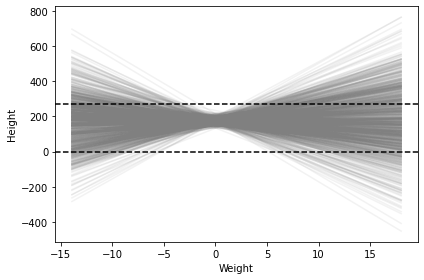

In [77]:
# Extract alpha, beta from the model posterior
alpha_samples = df_model_ppc['alpha'].values
beta_samples = df_model_ppc['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], 'gray', alpha=0.1)

# Plot minimum (0) and maximum heights observed in nature
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=272, color='black', linestyle='--')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [78]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [79]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df_height_2b_ppc = sim.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

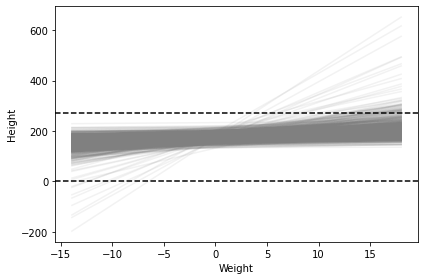

In [80]:
# Extract alpha, beta from the model posterior
alpha_samples = df_height_2b_ppc['alpha'].values
beta_samples = df_height_2b_ppc['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_sim['weight'], beta_samples[i] * data_sim['weight'] + alpha_samples[i], 'gray', alpha=0.1)

# Plot minimum (0) and maximum heights observed in nature (272)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=272, color='black', linestyle='--')

plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

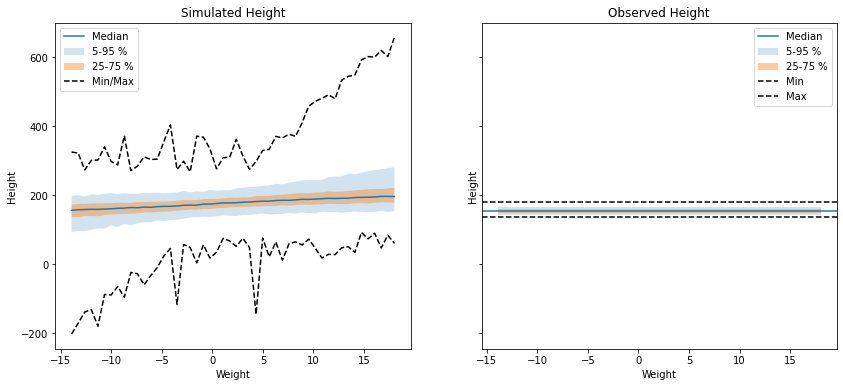

In [81]:
# Calculate percentiles
percentiles = np.percentile(df_height_2b_ppc.filter(regex='^height').to_numpy(), [0, 5, 25, 50, 75, 95, 100], axis=0)
obs_percentiles = np.percentile(d.height, [0, 5, 25, 50, 75, 95, 100], axis=0)

_, ax = plt.subplots(ncols=2, nrows=1, figsize=[14,6], sharey=True)
ax[0].plot(data_sim['weight'], percentiles[3], label='Median')
ax[0].fill_between(data_sim['weight'], percentiles[1], percentiles[5], alpha=0.2, label='5-95 %')
ax[0].fill_between(data_sim['weight'], percentiles[2], percentiles[4], alpha=0.4, label='25-75 %')
ax[0].plot(data_sim['weight'], percentiles[0], 'k--', label='Min/Max')
ax[0].plot(data_sim['weight'], percentiles[-1], 'k--')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('Height')
ax[0].legend()
ax[0].set_title('Simulated Height')

ax[1].axhline(y=obs_percentiles[3], label='Median')
ax[1].fill_between(data_sim['weight'], obs_percentiles[1], obs_percentiles[5], alpha=0.2, label='5-95 %')
ax[1].fill_between(data_sim['weight'], obs_percentiles[2], obs_percentiles[4], alpha=0.4, label='25-75 %')
ax[1].axhline(y=obs_percentiles[0], color='black', linestyle='--', label='Min')
ax[1].axhline(y=obs_percentiles[-1], color='black', linestyle='--', label='Max')
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('Height')
ax[1].legend()
ax[1].set_title('Observed Height')
plt.show()


Yes, the observed data can be consistent with the prior model if the model incorporates relevant prior information or assumptions.

## Task 6. Fitting and evaluating model


In [82]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [83]:
N = 50
data_fit={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'list_of_heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit, seed=28052020)

df_model_2_fit = fit.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)

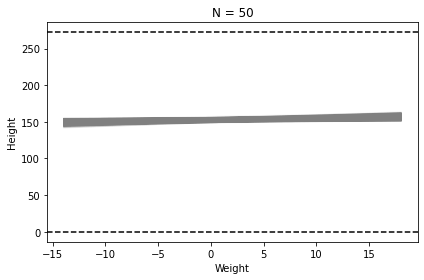

In [84]:
# Extract alpha, beta from the model posterior
alpha_samples = df_model_2_fit['alpha'].values
beta_samples = df_model_2_fit['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_fit['weight'], beta_samples[i] * data_fit['weight'] + alpha_samples[i], 'gray', alpha=0.1)

# Plot minimum (0) and maximum heights observed in nature (272)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=272, color='black', linestyle='--')

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


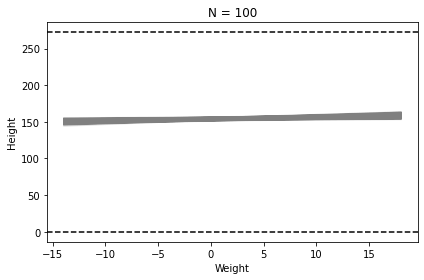

In [85]:
N = 100
data_fit_100={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'list_of_heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit_100, seed=28052020)

df_model_2_fit_100 = fit.draws_pd()

# Extract alpha, beta from the model posterior
alpha_samples = df_model_2_fit_100['alpha'].values
beta_samples = df_model_2_fit_100['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_fit_100['weight'], beta_samples[i] * data_fit_100['weight'] + alpha_samples[i], 'gray', alpha=0.1)

# Plot minimum (0) and maximum heights observed in nature (272)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=272, color='black', linestyle='--')

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)








chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


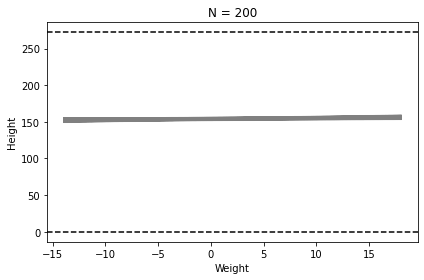

In [86]:
N = 200
data_fit_200={'N':N, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max(), num=N), 'list_of_heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit_200, seed=28052020)

df_model_2_fit_200 = fit.draws_pd()

# Extract alpha, beta from the model posterior
alpha_samples = df_model_2_fit_200['alpha'].values
beta_samples = df_model_2_fit_200['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_fit_200['weight'], beta_samples[i] * data_fit_200['weight'] + alpha_samples[i], 'gray', alpha=0.1)

# Plot minimum (0) and maximum heights observed in nature (272)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=272, color='black', linestyle='--')

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


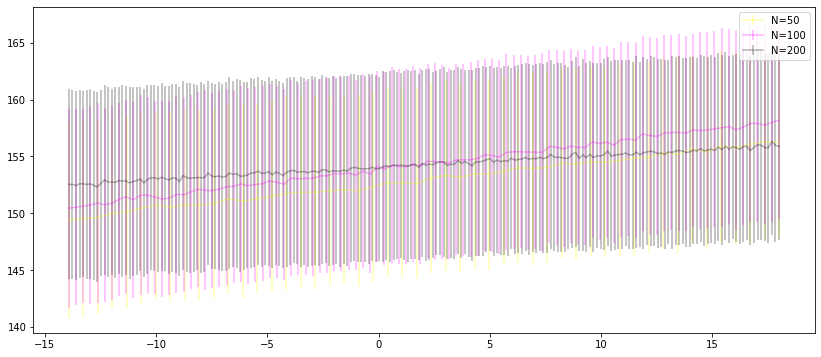

In [97]:
mean_50, std_50 = df_model_2_fit.iloc[:,-50:].mean(),  df_model_2_fit.iloc[:,-50:].std()
mean_100, std_100 = df_model_2_fit_100.iloc[:,-100:].mean(), df_model_2_fit_100.iloc[:,-100:].std()
mean_200, std_200 = df_model_2_fit_200.iloc[:,-200:].mean(), df_model_2_fit_200.iloc[:,-200:].std() 

_, ax = plt.subplots(nrows=1, ncols=1, figsize=[14,6])

ax.errorbar(x=data_fit['weight'], y=mean_50, yerr=std_50, alpha=0.3, color='yellow', label='N=50')
ax.errorbar(x=data_fit_100['weight'], y=mean_100, yerr=std_100, alpha=0.3, color='magenta', label='N=100')
ax.errorbar(x=data_fit_200['weight'], y=mean_200, yerr=std_200, alpha=0.3, color='black', label='N=200')
plt.legend()
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case? 

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


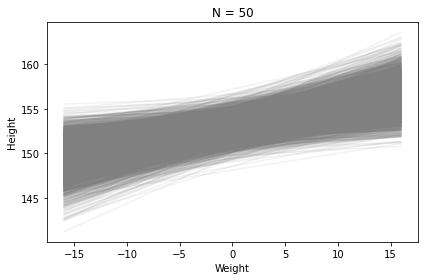

In [105]:
N = 50
weight = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N) - np.linspace(d.c_weight.min(), d.c_weight.max(), num=N).mean()
data_fit={'N':N, 'weight':weight, 'list_of_heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit, seed=28052020)

df_model_2_fit = fit.draws_pd()

# Extract alpha, beta from the model posterior
alpha_samples = df_model_2_fit['alpha'].values
beta_samples = df_model_2_fit['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_fit['weight'], beta_samples[i] * data_fit['weight'] + alpha_samples[i], 'gray', alpha=0.1)

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

The interpretation of $\alpha$ changes from the value of the response variable when all predictor variables are zero to the expected value of the response variable when the predictor variable is at its mean value after centering the data.

2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


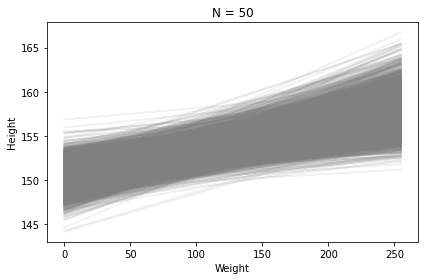

In [104]:
N = 50
weight = np.linspace(d.c_weight.min(), d.c_weight.max(), num=N) - np.linspace(d.c_weight.min(), d.c_weight.max(), num=N).mean()
data_fit={'N':N, 'weight':weight**2, 'list_of_heights':d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit, seed=28052020)

df_model_2_fit = fit.draws_pd()

# Extract alpha, beta from the model posterior
alpha_samples = df_model_2_fit['alpha'].values
beta_samples = df_model_2_fit['beta'].values

# Plot lines for each sampled alpha and beta
for i in range(len(alpha_samples)):
    plt.plot(data_fit['weight'], beta_samples[i] * data_fit['weight'] + alpha_samples[i], 'gray', alpha=0.1)

plt.title('N = {}'.format(N))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()